# Churn, Baby, Churn

What's driving customer churn? Can we predict it?

## Getting and Cleaning the Data

We'll start with some standard imports

In [213]:
import pandas as pd
import itertools as it

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ttest_ind

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# ignore warning
import warnings
warnings.filterwarnings("ignore")

We'll acquire our data from a mysql database, credentials are stored (and hidden) in a separate `.py` file.

In [214]:
import env

url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/telco_churn'
query = 'SELECT * FROM customers'
df = pd.read_sql(query, url)

In [215]:
df.dtypes

customer_id                  object
gender                       object
senior_citizen                int64
partner                      object
dependents                   object
tenure                        int64
phone_service                object
multiple_lines               object
internet_service_type_id      int64
online_security              object
online_backup                object
device_protection            object
tech_support                 object
streaming_tv                 object
streaming_movies             object
contract_type_id              int64
paperless_billing            object
payment_type_id               int64
monthly_charges             float64
total_charges                object
churn                        object
dtype: object

Let's take a quick look at all the data together:

In [216]:
def peekatdata(df: pd.DataFrame):
    print('- Shape')
    print(df.shape)
    print('- Head and Tail')
    print(pd.concat([df.head(), df.tail()]))
    print('- Numeric Vars')
    print(df.describe())
    print('- String Columns')
    for col in df.select_dtypes('object'):
        print('--- {}'.format(col))
        print(df[col].value_counts().head())

peekatdata(df)

- Shape
(7043, 21)
- Head and Tail
     customer_id  gender  senior_citizen partner dependents  tenure  \
0     0002-ORFBO  Female               0     Yes        Yes       9   
1     0003-MKNFE    Male               0      No         No       9   
2     0004-TLHLJ    Male               0      No         No       4   
3     0011-IGKFF    Male               1     Yes         No      13   
4     0013-EXCHZ  Female               1     Yes         No       3   
7038  9987-LUTYD  Female               0      No         No      13   
7039  9992-RRAMN    Male               0     Yes         No      22   
7040  9992-UJOEL    Male               0      No         No       2   
7041  9993-LHIEB    Male               0     Yes        Yes      67   
7042  9995-HOTOH    Male               0     Yes        Yes      63   

     phone_service    multiple_lines  internet_service_type_id  \
0              Yes                No                         1   
1              Yes               Yes               

It looks like customer id is a numeric id that uniquely identifies each row, let's verify this, and if it is unique, we can use it as our index.

In [217]:
df.customer_id.value_counts().mean()

1.0

In [218]:
df.set_index('customer_id', inplace=True)

It looks like pandas thinks the `total_charges` column is a string, let's investigate this further.

In [219]:
(df.total_charges.str.strip() == '').sum()

11

It looks as though there are some rows that have an empty string or a space in them.

Since there's such a small number of rows, we'll just drop them.

In [220]:
df = df[~ (df.total_charges.str.strip() == '')]

And go ahead and correct the data type of the column.

In [221]:
df.total_charges = df.total_charges.astype('float')

Let's take a closer look at our numeric columns:

In [222]:
for col in df.select_dtypes('number'):
    print(f'\n- {col}')
    print(df[col].value_counts(bins=4))


- senior_citizen
(-0.002, 0.25]    5890
(0.75, 1.0]       1142
(0.5, 0.75]          0
(0.25, 0.5]          0
Name: senior_citizen, dtype: int64

- tenure
(0.928, 18.75]    2723
(54.25, 72.0]     1819
(18.75, 36.5]     1308
(36.5, 54.25]     1182
Name: tenure, dtype: int64

- internet_service_type_id
(1.5, 2.0]      3096
(0.997, 1.5]    2416
(2.5, 3.0]      1520
(2.0, 2.5]         0
Name: internet_service_type_id, dtype: int64

- contract_type_id
(0.997, 1.5]    3875
(2.5, 3.0]      1685
(1.5, 2.0]      1472
(2.0, 2.5]         0
Name: contract_type_id, dtype: int64

- payment_type_id
(0.996, 1.75]    2365
(1.75, 2.5]      1604
(2.5, 3.25]      1542
(3.25, 4.0]      1521
Name: payment_type_id, dtype: int64

- monthly_charges
(68.5, 93.625]                  2288
(18.148999999999997, 43.375]    1893
(93.625, 118.75]                1477
(43.375, 68.5]                  1374
Name: monthly_charges, dtype: int64

- total_charges
(10.133000000000001, 2185.3]    4305
(2185.3, 4351.8]            

It doesn't look like there's any outliers we need to handle here.

Let's see if there's any null values:

In [223]:
df.isna().sum()

gender                      0
senior_citizen              0
partner                     0
dependents                  0
tenure                      0
phone_service               0
multiple_lines              0
internet_service_type_id    0
online_security             0
online_backup               0
device_protection           0
tech_support                0
streaming_tv                0
streaming_movies            0
contract_type_id            0
paperless_billing           0
payment_type_id             0
monthly_charges             0
total_charges               0
churn                       0
dtype: int64

Looks good!

Lastly, let's encode churn so that we can treat it as a number.

In [224]:
df.churn = (df.churn.str.lower() == 'yes').astype('int')

### Feature Engineering

It looks like there is redundant information in the `phone_service` and `multiple_lines` columns. Let's combine them into a single feature.

In [225]:
df[['phone_service', 'multiple_lines']].head()

,phone_service,multiple_lines
customer_id,,
0002-ORFBO,Yes,No
0003-MKNFE,Yes,Yes
0004-TLHLJ,Yes,No
0011-IGKFF,Yes,No
0013-EXCHZ,Yes,No


We'll use the following values for our transformation:

- 0: no phone service
- 1: phone service
- 2: phone service and multiple lines

First a quick sanity check; there shouldn't be any customers that have multiple lines but no phone service:

In [226]:
pd.crosstab(df.phone_service, df.multiple_lines)

multiple_lines,No,No phone service,Yes
phone_service,,,
No,0,680,0
Yes,3385,0,2967


Good! Let's apply the transformation and drop the old columns.

In [227]:
df['phone_id'] = (df.phone_service == 'Yes').astype('int') + (df.multiple_lines == 'Yes').astype('int')
df.drop(['phone_service', 'multiple_lines'], axis=1, inplace=True)

Let's see if we can combine the `partner` and `dependents` columns, it seems like there might be some redundant information there.

In [228]:
pd.crosstab(df.partner, df.dependents)

dependents,No,Yes
partner,,
No,3280,359
Yes,1653,1740


While technically we're losing a little bit of information, we'll follow a similar encoding pattern here. A high value indicates a partner and dependents, 0 indicates none. Specifically:

- 0: no partner or dependents
- 1: either a partner or dependents
- 2: both a partner and dependents

In [229]:
df['household_type'] = (df.partner == 'Yes').astype('int') + (df.dependents == 'Yes').astype('int')
df.drop(['dependents', 'partner'], axis=1, inplace=True)

We can do another similar transformation for both streaming services and online security and backups

In [230]:
df['streaming_services'] = (df.streaming_tv == 'Yes').astype('int') + (df.streaming_movies == 'Yes').astype('int')
df.drop(['streaming_tv', 'streaming_movies'], axis=1, inplace=True)

df['cloud_services'] = (df.online_backup == 'Yes').astype('int') + (df.online_security == 'Yes').astype('int')
df.drop(['online_backup', 'online_security'], axis=1, inplace=True)

### Train Test Split

In [231]:
train, test = train_test_split(df, train_size=.7, test_size=.3, random_state=42)

We'll do some min-max scaling on `montly_charges` and `total_charges` so that they will play nicer with our logistic regression model later on.

In [232]:
cols = ['monthly_charges', 'total_charges']

scaler = MinMaxScaler()
scaler.fit(train[cols])

train.loc[:, cols] = scaler.transform(train[cols])
test.loc[:, cols] = scaler.transform(test[cols])

## Exploration

Does tenure influence the rate of churn?

Text(0.5, 0, 'Months w/ Company')

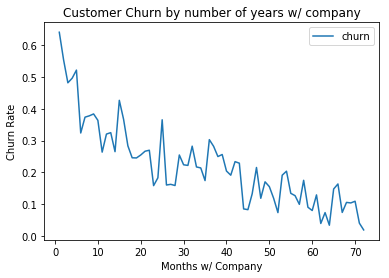

In [233]:
train[['tenure', 'churn']].groupby('tenure').mean().plot()
plt.title('Customer Churn by number of years w/ company')
plt.ylabel('Churn Rate')
plt.xlabel('Months w/ Company')

Seems like there's a trend there. Let's smooth out the data and look at tenure by years instead of by months.

Text(0.5, 0, 'Years w/ Company')

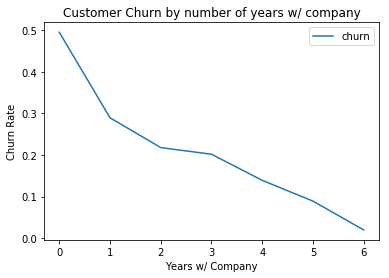

In [234]:
train['tenure_years'] = (train.tenure / 12).astype(int)

train[['tenure_years', 'churn']].groupby('tenure_years').mean().plot()
plt.title('Customer Churn by number of years w/ company')
plt.ylabel('Churn Rate')
plt.xlabel('Years w/ Company')

Is there any one feature that indicates whether or not the customer will churn?

We can write some code that will give us the churn rate for every group, as well as performing a chi-squared test comparing the churn rate in each group.

In [375]:
train.head()
train.groupby(['internet_service_type_id', 'device_protection','phone_id', 'churn'])
                ['monthly_charges'].mean()

internet_service_type_id  device_protection    phone_id  churn
1                         No                   0         0       0.190568
                                                         1       0.158505
                                               1         0       0.378731
                                                         1       0.331446
                                               2         0       0.458289
                                                         1       0.396971
                          Yes                  0         0       0.314186
                                                         1       0.268864
                                               1         0       0.496372
                                                         1       0.418892
                                               2         0       0.609595
                                                         1       0.550284
2                         No                   1 

In [355]:
categorical_cols = train.drop(['churn', 'tenure', 'tenure_years', 'monthly_charges', 'total_charges'], axis=1).columns

In [376]:
from scipy.stats import chisquare, chi2_contingency

def chi2(df, categorical_columns):
    p_val = []
    for i, col in enumerate(categorical_cols):
        col_churn = pd.crosstab(df[col], df['churn'], margins=False).reset_index()
        col_churn.columns = [col, 'no_churn', 'yes_churn']
        chi2, p, dof, expected = chi2_contingency(col_churn.drop(columns=[col]))
        p_val.append(p)
    all_cats = pd.DataFrame({'Category': categorical_cols, 'P_Value': p_val})
    return all_cats

In [377]:
all_cats = chi2(train, categorical_cols) 
all_cats[all_cats['P_Value']>.05]

,Category,P_Value
0,gender,0.508050


In [378]:
all_cats[all_cats['P_Value']<=.05]

,Category,P_Value
1,senior_citizen,0.000000
2,internet_service_type_id,0.000000
3,device_protection,0.000000
4,tech_support,0.000000
5,contract_type_id,0.000000
6,paperless_billing,0.000000
7,payment_type_id,0.000000
8,phone_id,0.006650
9,household_type,0.000000
10,streaming_services,0.000000


In [380]:
col = 'tech_support'
col_churn = pd.crosstab(train[col],train['churn'], margins=False).reset_index()
col_churn.columns = [col, 'no_churn', 'yes_churn']
col_churn


,tech_support,no_churn,yes_churn
0,No,1399,1011
1,No internet service,984,79
2,Yes,1226,223


In [381]:
chi2, p, dof, expected = chi2_contingency(col_churn.drop(columns=[col]))
print("Probability that the difference in churn proportion \nfor all customers with vs. without tech support \nis due to chance: %f " %p)
chi2

Probability that the difference in churn proportion 
for all customers with vs. without tech support 
is due to chance: 0.000000 


583.0753923461807

In [363]:
col = 'tech_support'
fiber = train[train['internet_service_type_id']==2]
col_churn = pd.crosstab(fiber[col],fiber['churn'], margins=False).reset_index()
col_churn.columns = [col, 'no_churn', 'yes_churn']
col_churn

,tech_support,no_churn,yes_churn
0,No,779,763
1,Yes,473,144


In [364]:
chi2, p, dof, expected = chi2_contingency(col_churn.drop(columns=[col]))
print("Probability that the difference in churn proportion \nfor fiber customers with vs. without tech support \nis due to chance: %f " %p)

Probability that the difference in churn proportion 
for fiber customers with vs. without tech support 
is due to chance: 0.000000 


In [365]:
col = 'tech_support'
fiber_senior = train[(train['internet_service_type_id'] == 2) &
            (train['senior_citizen'] == 1)]
col_churn = pd.crosstab(fiber_senior[col],fiber_senior['churn'], margins=False).reset_index()
col_churn.columns = [col, 'no_churn', 'yes_churn']
col_churn

,tech_support,no_churn,yes_churn
0,No,201,252
1,Yes,97,31


In [366]:
chi2, p, dof, expected = chi2_contingency(col_churn.drop(columns=[col]))
print("Probability that the difference in churn proportion for \nsenior citizen fiber customers for those with vs. without \ntech support is due to chance: %f " %p)

Probability that the difference in churn proportion for 
senior citizen fiber customers for those with vs. without 
tech support is due to chance: 0.000000 


In [367]:
col = 'tech_support'
fiber_sr_m2m = train[(train['internet_service_type_id'] == 2) &
                     (train['senior_citizen'] == 1) &
                     (train['contract_type_id'] == 1)]
col_churn = pd.crosstab(fiber_sr_m2m[col],fiber_sr_m2m['churn'], margins=False).reset_index()
col_churn.columns = [col, 'no_churn', 'yes_churn']
col_churn

,tech_support,no_churn,yes_churn
0,No,153,244
1,Yes,27,21


In [368]:
chi2, p, dof, expected = chi2_contingency(col_churn.drop(columns=[col]))
print("Probability that the difference in churn proportion for \nsenior citizen fiber customers on a m2m contract \nfor those with vs. without tech support is due to chance: %f " %p)

Probability that the difference in churn proportion for 
senior citizen fiber customers on a m2m contract 
for those with vs. without tech support is due to chance: 0.027400 


In [369]:
col = 'tech_support'
fiber_m2m = train[(train['internet_service_type_id'] == 2) &
                  (train['contract_type_id'] == 1)]
col_churn = pd.crosstab(fiber_m2m[col],fiber_m2m['churn'], margins=False).reset_index()
col_churn.columns = [col, 'no_churn', 'yes_churn']
col_churn

,tech_support,no_churn,yes_churn
0,No,526,715
1,Yes,146,97


In [371]:
chi2, p, dof, expected = chi2_contingency(col_churn.drop(columns=[col]))
print("Probability that the difference in churn proportion for \nfiber customers on a m2m contract \nfor those with vs. without tech support is due to chance: %f " %p)

Probability that the difference in churn proportion for 
fiber customers on a m2m contract 
for those with vs. without tech support is due to chance: 0.000001 


In [78]:
import scipy as sp 
import numpy as np

churn = [1,2,3]
not_churn = [4,5,6]
sp.stats.ttest_ind(
    stage_right,
    stage_left)

Ttest_indResult(statistic=-3.6742346141747673, pvalue=0.021311641128756727)

Is there a price threshold where churn increases past a certain point?